In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import keras

# Check versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# List available functions and classes in tensorflow.keras.layers
print("\nAvailable functions and classes in tensorflow.keras.layers:")
print(dir(tf.keras.layers))

# List available functions and classes in keras.layers
print("\nAvailable functions and classes in keras.layers:")
print(dir(keras.layers))

TensorFlow version: 2.15.0
Keras version: 2.15.0

Available functions and classes in tensorflow.keras.layers:
['AbstractRNNCell', 'Activation', 'ActivityRegularization', 'Add', 'AdditiveAttention', 'AlphaDropout', 'Attention', 'Average', 'AveragePooling1D', 'AveragePooling2D', 'AveragePooling3D', 'AvgPool1D', 'AvgPool2D', 'AvgPool3D', 'BatchNormalization', 'Bidirectional', 'CategoryEncoding', 'CenterCrop', 'Concatenate', 'Conv1D', 'Conv1DTranspose', 'Conv2D', 'Conv2DTranspose', 'Conv3D', 'Conv3DTranspose', 'ConvLSTM1D', 'ConvLSTM2D', 'ConvLSTM3D', 'Convolution1D', 'Convolution1DTranspose', 'Convolution2D', 'Convolution2DTranspose', 'Convolution3D', 'Convolution3DTranspose', 'Cropping1D', 'Cropping2D', 'Cropping3D', 'Dense', 'DenseFeatures', 'DepthwiseConv1D', 'DepthwiseConv2D', 'Discretization', 'Dot', 'Dropout', 'ELU', 'EinsumDense', 'Embedding', 'Flatten', 'GRU', 'GRUCell', 'GaussianDropout', 'GaussianNoise', 'GlobalAveragePooling1D', 'GlobalAveragePooling2D', 'GlobalAveragePooling3D

# Reading the data input

# Prepare the dataset

In [3]:
batch_size = 32
img_height = 256
img_width = 256
rnd_seed = 123
random.seed(rnd_seed)

# Model 1: Standard Model

In [4]:
data_dir_train = pathlib.Path("Train3")
data_dir_test = pathlib.Path("Test")

In [5]:
# Define the paths to train and test folders
train_folder_path = data_dir_train
test_folder_path = data_dir_test

def count_files_in_class_folders(base_path):
    class_folders = os.listdir(base_path)
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):  # Ensure it's a directory
            file_count = len(glob(class_folder_path + '/*'))
            print(f"Class '{class_folder}' has {file_count} files.")

# Count files in each class folder in train folder
print("Train folder:")
count_files_in_class_folders(train_folder_path)

# Count files in each class folder in test folder
print("Test folder:")
count_files_in_class_folders(test_folder_path)

Train folder:
Class 'actinic keratosis' has 1000 files.
Class 'basal cell carcinoma' has 1000 files.
Class 'dermatofibroma' has 1000 files.
Class 'melanoma' has 1000 files.
Class 'nevus' has 1000 files.
Class 'pigmented benign keratosis' has 1000 files.
Class 'seborrheic keratosis' has 1000 files.
Class 'squamous cell carcinoma' has 1000 files.
Class 'vascular lesion' has 1000 files.
Test folder:
Class 'actinic keratosis' has 69 files.
Class 'basal cell carcinoma' has 106 files.
Class 'dermatofibroma' has 26 files.
Class 'melanoma' has 313 files.
Class 'nevus' has 1425 files.
Class 'pigmented benign keratosis' has 96 files.
Class 'seborrheic keratosis' has 235 files.
Class 'squamous cell carcinoma' has 40 files.
Class 'vascular lesion' has 29 files.


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2339 files belonging to 9 classes.
Using 2105 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.11185297 0.80818045


In [13]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the Early Stopping Callback with min_delta
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               min_delta=0.001,     # Minimum change to qualify as an improvement
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       7

In [16]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/25
225/225 [==============================] - 251s 1s/step - loss: 2.1292 - accuracy: 0.2018 - val_loss: 1.8006 - val_accuracy: 0.3244
Epoch 2/25
225/225 [==============================] - 268s 1s/step - loss: 1.6963 - accuracy: 0.3604 - val_loss: 1.6049 - val_accuracy: 0.4039
Epoch 3/25
225/225 [==============================] - 266s 1s/step - loss: 1.5784 - accuracy: 0.3969 - val_loss: 1.5383 - val_accuracy: 0.4139
Epoch 4/25
225/225 [==============================] - 270s 1s/step - loss: 1.4670 - accuracy: 0.4369 - val_loss: 1.4229 - val_accuracy: 0.4606
Epoch 5/25
225/225 [==============================] - 258s 1s/step - loss: 1.3841 - accuracy: 0.4615 - val_loss: 1.4091 - val_accuracy: 0.4889
Epoch 6/25
225/225 [==============================] - 283s 1s/step - loss: 1.3175 - accuracy: 0.4928 - val_loss: 1.4295 - val_accuracy: 0.4472
Epoch 7/25
225/225 [==============================] - 261s 1s/step - loss: 1.2164 - accuracy: 0.5326 - val_loss: 1.4778 - val_accuracy: 0.4833

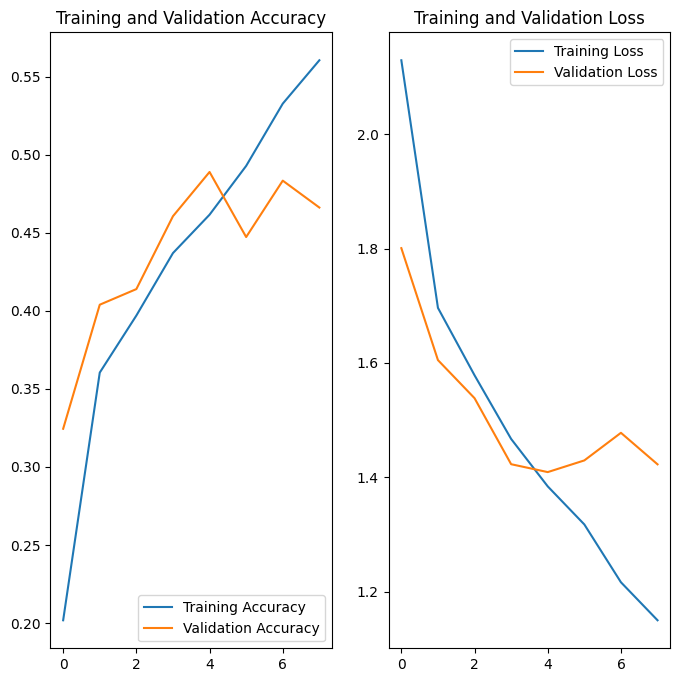

In [30]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

completed_epochs = len(history.history['accuracy'])
epochs_range = range(completed_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

66/66 [==============================] - 53s 243ms/step - loss: 1.4694 - accuracy: 0.5701


1/1 [==============================] - 0s 38ms/step
The model is not confident enough to make a prediction for this image.

Confidence scores for all classes:
This image belongs to actinic keratosis with a 9.79 percent confidence.
This image belongs to basal cell carcinoma with a 9.86 percent confidence.
This image belongs to dermatofibroma with a 9.73 percent confidence.
This image belongs to melanoma with a 19.12 percent confidence.
This image belongs to nevus with a 11.98 percent confidence.
This image belongs to pigmented benign keratosis with a 9.93 percent confidence.
This image belongs to seborrheic keratosis with a 9.89 percent confidence.
This image belongs to squamous cell carcinoma with a 9.93 percent confidence.
This image belongs to vascular lesion with a 9.78 percent confidence.


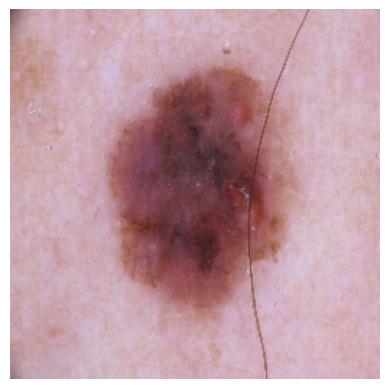

In [22]:
img_path = "ISIC_0000139.jpg"

# Define a confidence threshold
confidence_threshold = 50.0  # Set an appropriate threshold for your use case

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Check if the highest confidence score meets the threshold
if 100 * np.max(score) < confidence_threshold:
    print("The model is not confident enough to make a prediction for this image.")
else:
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("\nConfidence scores for all classes:")
for i, class_name in enumerate(class_names):
    print("This image belongs to {} with a {:.2f} percent confidence.".format(class_name, 100 * score[i]))
    
# Preview the image
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.axis('off')
plt.show()

In [45]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)      

In [47]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


225/225 [==============================] - 169s 747ms/step - loss: 2.1329 - accuracy: 0.1665 - val_loss: 1.9508 - val_accuracy: 0.2528
Epoch 2/10
225/225 [==============================] - 169s 753ms/step - loss: 1.8498 - accuracy: 0.3064 - val_loss: 1.7513 - val_accuracy: 0.3400
Epoch 3/10
225/225 [==============================] - 171s 759ms/step - loss: 1.6740 - accuracy: 0.3768 - val_loss: 1.6366 - val_accuracy: 0.4256
Epoch 4/10
225/225 [==============================] - 168s 748ms/step - loss: 1.5418 - accuracy: 0.4225 - val_loss: 1.4905 - val_accuracy: 0.4494
Epoch 5/10
225/225 [==============================] - 168s 747ms/step - loss: 1.4856 - accuracy: 0.4490 - val_loss: 1.5209 - val_accuracy: 0.4439
Epoch 6/10
225/225 [==============================] - 169s 751ms/step - loss: 1.4113 - accuracy: 0.4768 - val_loss: 1.4727 - val_accuracy: 0.4394
Epoch 7/10
225/225 [==============================] - 168s 748ms/step - loss: 1.3411 - accuracy: 0.5025 - val_loss: 1.4990 - val_accura

1/1 [==============================] - 0s 429ms/step
The model is not confident enough to make a prediction for this image.

Confidence scores for all classes:
This image belongs to actinic keratosis with a 9.76 percent confidence.
This image belongs to basal cell carcinoma with a 9.80 percent confidence.
This image belongs to dermatofibroma with a 9.76 percent confidence.
This image belongs to melanoma with a 15.49 percent confidence.
This image belongs to nevus with a 15.74 percent confidence.
This image belongs to pigmented benign keratosis with a 9.97 percent confidence.
This image belongs to seborrheic keratosis with a 9.94 percent confidence.
This image belongs to squamous cell carcinoma with a 9.78 percent confidence.
This image belongs to vascular lesion with a 9.75 percent confidence.


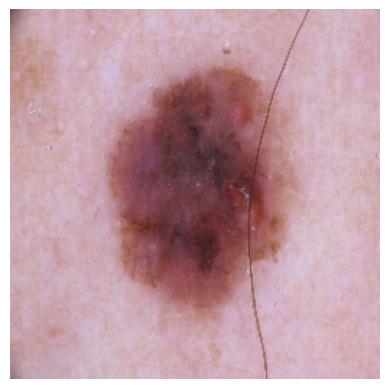

In [49]:
img_path = "ISIC_0000139.jpg"

# Define a confidence threshold
confidence_threshold = 50.0  # Set an appropriate threshold for your use case

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Check if the highest confidence score meets the threshold
if 100 * np.max(score) < confidence_threshold:
    print("The model is not confident enough to make a prediction for this image.")
else:
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("\nConfidence scores for all classes:")
for i, class_name in enumerate(class_names):
    print("This image belongs to {} with a {:.2f} percent confidence.".format(class_name, 100 * score[i]))
    
# Preview the image
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.axis('off')
plt.show()

In [52]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

66/66 [==============================] - 14s 216ms/step - loss: 1.5389 - accuracy: 0.5601


In [54]:
data_dir_train = pathlib.Path("Train2")
data_dir_test = pathlib.Path("Test")

In [55]:
# Define the paths to train and test folders
train_folder_path = data_dir_train
test_folder_path = data_dir_test

def count_files_in_class_folders(base_path):
    class_folders = os.listdir(base_path)
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):  # Ensure it's a directory
            file_count = len(glob(class_folder_path + '/*'))
            print(f"Class '{class_folder}' has {file_count} files.")

# Count files in each class folder in train folder
print("Train folder:")
count_files_in_class_folders(train_folder_path)

# Count files in each class folder in test folder
print("Test folder:")
count_files_in_class_folders(test_folder_path)

Train folder:
Class 'actinic keratosis' has 250 files.
Class 'basal cell carcinoma' has 250 files.
Class 'dermatofibroma' has 105 files.
Class 'melanoma' has 800 files.
Class 'nevus' has 800 files.
Class 'pigmented benign keratosis' has 250 files.
Class 'seborrheic keratosis' has 858 files.
Class 'squamous cell carcinoma' has 179 files.
Class 'vascular lesion' has 116 files.
Test folder:
Class 'actinic keratosis' has 69 files.
Class 'basal cell carcinoma' has 106 files.
Class 'dermatofibroma' has 26 files.
Class 'melanoma' has 313 files.
Class 'nevus' has 1425 files.
Class 'pigmented benign keratosis' has 96 files.
Class 'seborrheic keratosis' has 235 files.
Class 'squamous cell carcinoma' has 40 files.
Class 'vascular lesion' has 29 files.


In [56]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3608 files belonging to 9 classes.
Using 2887 files for training.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3608 files belonging to 9 classes.
Using 721 files for validation.


In [59]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2339 files belonging to 9 classes.
Using 2105 files for validation.


In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [72]:
num_classes = 9
model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [73]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 45, 45, 128)     

In [75]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/30
91/91 [==============================] - 37s 370ms/step - loss: 2.0009 - accuracy: 0.2286 - val_loss: 1.8102 - val_accuracy: 0.2455
Epoch 2/30
91/91 [==============================] - 32s 355ms/step - loss: 1.7652 - accuracy: 0.3675 - val_loss: 1.7399 - val_accuracy: 0.3564
Epoch 3/30
91/91 [==============================] - 33s 363ms/step - loss: 1.7125 - accuracy: 0.3914 - val_loss: 1.6219 - val_accuracy: 0.4078
Epoch 4/30
91/91 [==============================] - 33s 365ms/step - loss: 1.6456 - accuracy: 0.4163 - val_loss: 1.5511 - val_accuracy: 0.4341
Epoch 5/30
91/91 [==============================] - 32s 355ms/step - loss: 1.6102 - accuracy: 0.4292 - val_loss: 1.5195 - val_accuracy: 0.4494
Epoch 6/30
91/91 [==============================] - 32s 352ms/step - loss: 1.5930 - accuracy: 0.4309 - val_loss: 1.5421 - val_accuracy: 0.4258
Epoch 7/30
91/91 [==============================] - 32s 347ms/step - loss: 1.5407 - accuracy: 0.4451 - val_loss: 1.5209 - val_accuracy: 0.4480

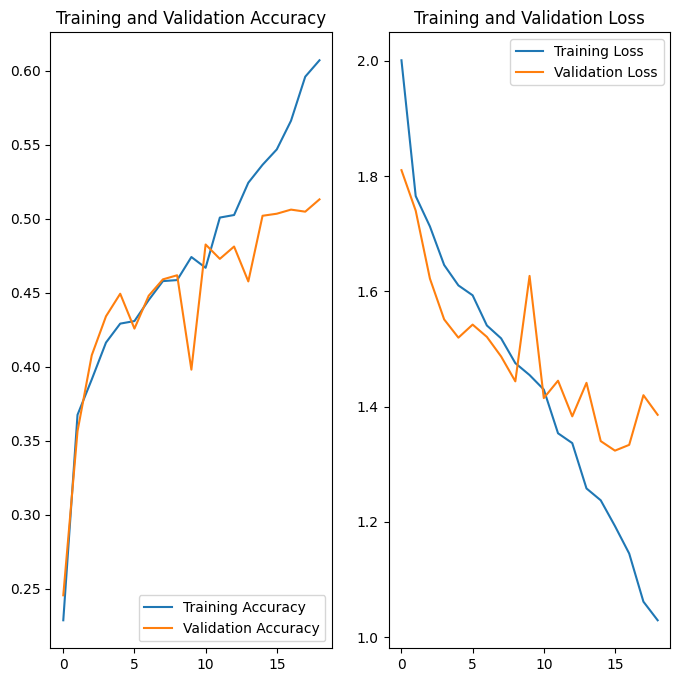

In [77]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

completed_epochs = len(history.history['accuracy'])
epochs_range = range(completed_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [78]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

66/66 [==============================] - 8s 117ms/step - loss: 1.1647 - accuracy: 0.5995


1/1 [==============================] - 0s 22ms/step
The model is not confident enough to make a prediction for this image.

Confidence scores for all classes:
This image belongs to actinic keratosis with a 10.44 percent confidence.
This image belongs to basal cell carcinoma with a 9.97 percent confidence.
This image belongs to dermatofibroma with a 10.03 percent confidence.
This image belongs to melanoma with a 13.56 percent confidence.
This image belongs to nevus with a 12.78 percent confidence.
This image belongs to pigmented benign keratosis with a 10.36 percent confidence.
This image belongs to seborrheic keratosis with a 11.98 percent confidence.
This image belongs to squamous cell carcinoma with a 10.99 percent confidence.
This image belongs to vascular lesion with a 9.90 percent confidence.


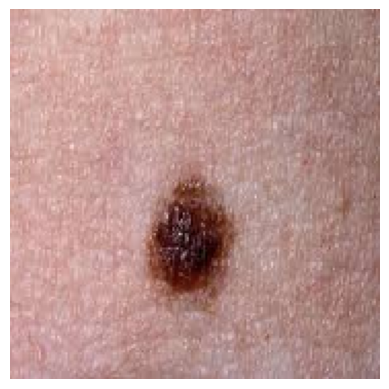

In [84]:
img_path = "nv2.jpeg"

# Define a confidence threshold
confidence_threshold = 50.0  # Set an appropriate threshold for your use case

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Check if the highest confidence score meets the threshold
if 100 * np.max(score) < confidence_threshold:
    print("The model is not confident enough to make a prediction for this image.")
else:
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("\nConfidence scores for all classes:")
for i, class_name in enumerate(class_names):
    print("This image belongs to {} with a {:.2f} percent confidence.".format(class_name, 100 * score[i]))
    
# Preview the image
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.axis('off')
plt.show()

In [86]:
data_dir_train = pathlib.Path("Train4")
data_dir_test = pathlib.Path("Test4")

In [87]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

654
459


In [111]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 739 files belonging to 3 classes.
Using 592 files for training.


In [112]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 739 files belonging to 3 classes.
Using 147 files for validation.


In [113]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 459 files belonging to 3 classes.
Using 413 files for validation.


In [91]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [98]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [99]:
num_classes = 9
model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [100]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 45, 45, 128)     

In [101]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/30
17/17 [==============================] - 8s 427ms/step - loss: 1.6067 - accuracy: 0.3378 - val_loss: 1.1857 - val_accuracy: 0.2615
Epoch 2/30
17/17 [==============================] - 7s 416ms/step - loss: 1.2295 - accuracy: 0.3721 - val_loss: 1.1372 - val_accuracy: 0.3769
Epoch 3/30
17/17 [==============================] - 7s 419ms/step - loss: 1.1471 - accuracy: 0.3550 - val_loss: 1.1065 - val_accuracy: 0.3769
Epoch 4/30
17/17 [==============================] - 7s 432ms/step - loss: 1.1186 - accuracy: 0.3378 - val_loss: 1.0993 - val_accuracy: 0.3615
Epoch 5/30
17/17 [==============================] - 8s 470ms/step - loss: 1.1075 - accuracy: 0.3798 - val_loss: 1.1323 - val_accuracy: 0.3615
Epoch 6/30
17/17 [==============================] - 8s 454ms/step - loss: 1.1034 - accuracy: 0.3817 - val_loss: 1.1045 - val_accuracy: 0.3769
Epoch 7/30
17/17 [==============================] - 8s 488ms/step - loss: 1.1153 - accuracy: 0.3721 - val_loss: 1.0899 - val_accuracy: 0.3615
Epoch 

In [103]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

13/13 [==============================] - 3s 113ms/step - loss: 0.9404 - accuracy: 0.6998


In [106]:
# Define the paths to train and test folders
train_folder_path = data_dir_train
test_folder_path = data_dir_test

def count_files_in_class_folders(base_path):
    class_folders = os.listdir(base_path)
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):  # Ensure it's a directory
            file_count = len(glob(class_folder_path + '/*'))
            print(f"Class '{class_folder}' has {file_count} files.")

# Count files in each class folder in train folder
print("Train folder:")
count_files_in_class_folders(train_folder_path)

# Count files in each class folder in test folder
print("Test folder:")
count_files_in_class_folders(test_folder_path)

Train folder:
Class 'basal cell carcinoma' has 250 files.
Class 'melanoma' has 225 files.
Class 'squamous cell carcinoma' has 264 files.
Test folder:
Class 'basal cell carcinoma' has 106 files.
Class 'melanoma' has 313 files.
Class 'squamous cell carcinoma' has 40 files.


In [114]:
class_names = train_ds.class_names
print(class_names)

['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']


1/1 [==============================] - 0s 30ms/step
The model is not confident enough to make a prediction for this image.

Confidence scores for all classes:
This image belongs to basal cell carcinoma with a 13.76 percent confidence.
This image belongs to melanoma with a 14.95 percent confidence.
This image belongs to squamous cell carcinoma with a 12.43 percent confidence.


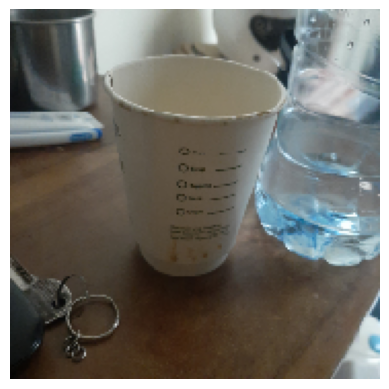

In [130]:
img_path = "ts2.png"

# Define a confidence threshold
confidence_threshold = 15.0  # Set an appropriate threshold for your use case

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Check if the highest confidence score meets the threshold
if 100 * np.max(score) < confidence_threshold:
    print("The model is not confident enough to make a prediction for this image.")
else:
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("\nConfidence scores for all classes:")
for i, class_name in enumerate(class_names):
    print("This image belongs to {} with a {:.2f} percent confidence.".format(class_name, 100 * score[i]))
    
# Preview the image
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.axis('off')
plt.show()

In [131]:
data_dir_train = pathlib.Path("Train5")
data_dir_test = pathlib.Path("Test5")

In [132]:
# Define the paths to train and test folders
train_folder_path = data_dir_train
test_folder_path = data_dir_test

def count_files_in_class_folders(base_path):
    class_folders = os.listdir(base_path)
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):  # Ensure it's a directory
            file_count = len(glob(class_folder_path + '/*'))
            print(f"Class '{class_folder}' has {file_count} files.")

# Count files in each class folder in train folder
print("Train folder:")
count_files_in_class_folders(train_folder_path)

# Count files in each class folder in test folder
print("Test folder:")
count_files_in_class_folders(test_folder_path)

Train folder:
Class 'melanoma' has 4592 files.
Class 'nevus' has 4539 files.
Test folder:
Class 'melanoma' has 1425 files.
Class 'nevus' has 1425 files.


In [133]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [134]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9131 files belonging to 2 classes.
Using 7305 files for training.


In [135]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9131 files belonging to 2 classes.
Using 1826 files for validation.


In [136]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2850 files belonging to 2 classes.
Using 2565 files for validation.


In [137]:
class_names = train_ds.class_names
print(class_names)

['melanoma', 'nevus']


In [138]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [143]:
num_classes = 9
model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 90, 90, 256)       147712    
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 45, 45, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 45, 45, 512)     

In [144]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [145]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/25
229/229 [==============================] - 546s 2s/step - loss: 0.6050 - accuracy: 0.6854 - val_loss: 0.4568 - val_accuracy: 0.7694
Epoch 2/25
229/229 [==============================] - 515s 2s/step - loss: 0.4419 - accuracy: 0.7878 - val_loss: 0.3696 - val_accuracy: 0.8499
Epoch 3/25
229/229 [==============================] - 516s 2s/step - loss: 0.3351 - accuracy: 0.8597 - val_loss: 0.3534 - val_accuracy: 0.8483
Epoch 4/25
229/229 [==============================] - 515s 2s/step - loss: 0.3065 - accuracy: 0.8631 - val_loss: 0.2876 - val_accuracy: 0.8855
Epoch 5/25
229/229 [==============================] - 516s 2s/step - loss: 0.2904 - accuracy: 0.8701 - val_loss: 0.2626 - val_accuracy: 0.8855
Epoch 6/25
229/229 [==============================] - 518s 2s/step - loss: 0.2619 - accuracy: 0.8820 - val_loss: 0.2744 - val_accuracy: 0.8795
Epoch 7/25
229/229 [==============================] - 514s 2s/step - loss: 0.2645 - accuracy: 0.8847 - val_loss: 0.3903 - val_accuracy: 0.8434

In [164]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

81/81 [==============================] - 50s 618ms/step - loss: 0.1706 - accuracy: 0.9216


1/1 [==============================] - 0s 39ms/step
The model is not confident enough to make a prediction for this image.

Confidence scores for all classes:
This image belongs to melanoma with a 14.89 percent confidence.
This image belongs to nevus with a 17.19 percent confidence.


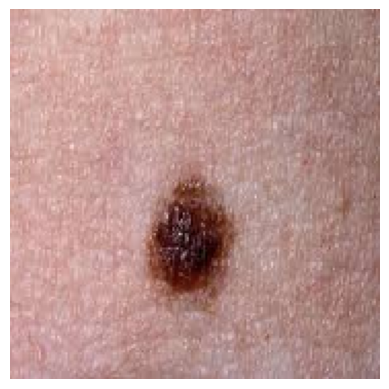

In [163]:
img_path = "nv2.jpeg"

# Define a confidence threshold
confidence_threshold = 20.0  # Set an appropriate threshold for your use case

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Check if the highest confidence score meets the threshold
if 100 * np.max(score) < confidence_threshold:
    print("The model is not confident enough to make a prediction for this image.")
else:
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("\nConfidence scores for all classes:")
for i, class_name in enumerate(class_names):
    print("This image belongs to {} with a {:.2f} percent confidence.".format(class_name, 100 * score[i]))
    
# Preview the image
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.axis('off')
plt.show()

In [166]:
#Create a file to save models
#model_path_1 = 'cnn_fc_model_full_04071300.h5'
#model.save(model_path_1)

In [1]:

data_dir_train = pathlib.Path("Train5")
data_dir_test = pathlib.Path("Test5")

NameError: name 'pathlib' is not defined

## Findings :
*   The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%.

*   The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features.

*  data imbalance might be causing the bais to the model.

# Model 2: Data augmentation with drop out layer